# A coincidence analysis walk-through

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyrepseq as prs
import pyrepseq.plotting as pp

from lib import *

plt.style.use('tcrspace.mplstyle')

In [2]:
cdr3_columns = {'alpha': 'cdr3_a_aa',
                'beta' : 'cdr3_b_aa'}

In [3]:
d = pd.read_csv(data_directory + 'dash_human.csv')
epitopes = d['epitope'].unique()

# Sequence-similarity clustermap

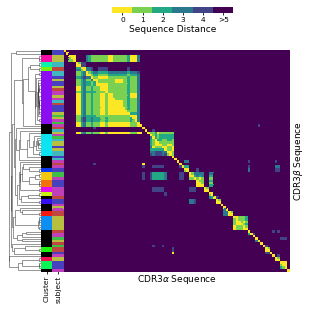

In [4]:
epitope = 'BMLF'
subject_color_mapper = lambda labels, **kwargs: pp.labels_to_colors_hls(labels,
                                                                         palette_kws=dict(l=0.5, s=0.5),
                                                                         **kwargs)
cluster_color_mapper = lambda labels, **kwargs: pp.labels_to_colors_hls(labels,
                                                                         palette_kws=dict(l=0.5, s=0.9),
                                                                         **kwargs)
cg, linkage, cluster = pp.similarity_clustermap(d[d['epitope']==epitope],
                                                 alpha_column=cdr3_columns['alpha'],
                                                 beta_column=cdr3_columns['beta'],
                                                 meta_columns=['subject'],
                                                 meta_to_colors=[cluster_color_mapper, subject_color_mapper])
plt.gcf().savefig('figures/raw/figure1A.svg'.format(epitope=epitope))

# Display pcDelta

In [5]:
back_norms, bins = prs.load_pcDelta_background()

In [6]:
hists = {}
chains = ['alpha', 'beta']
for epitope, dfg in d.groupby('epitope'):
    for chain in chains:
        hists[epitope, chain] = prs.pcDelta(dfg[cdr3_columns[chain]],
                                           bins=bins, pseudocount=0.0, normalize=True)
    hists[epitope, 'both'] = prs.pcDelta((dfg[cdr3_columns['alpha']], dfg[cdr3_columns['beta']]),
                                        pseudocount=0.0, normalize=True)

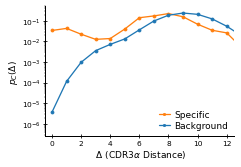

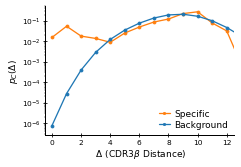

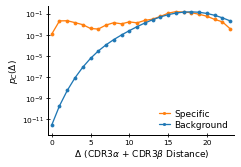

In [7]:
epitope = 'BMLF'
for chain in ['alpha', 'beta', 'both']:
    fig, ax = plt.subplots(figsize=(3.42, 2.4))
    l, = ax.plot(bins[:-1], hists[epitope, chain], '-o', label='Specific', ms=3, color='C1')
    ax.plot(bins[:-1], back_norms[chain], '-o', label='Background', ms=3, color='C0')
 
    ax.legend(loc='lower right')
    ax.set_yscale('log')
    xlabel = (r' $\Delta$ (CDR3$\alpha$ + CDR3$\beta$ Distance)' if chain == 'both'
              else r' $\Delta$ (CDR3$\{chain}$ Distance)'.format(chain=chain))
    ax.set_xlabel(xlabel)
    xmax = 23.5 if chain=='both' else 12.5
    ax.set_xticks(np.arange(0, xmax+1, 5 if chain=='both' else 2))
    ax.set_xlim(-0.5, xmax)
    ax.set_ylim(top=0.5, bottom=3e-13 if chain=='both' else 2.5e-7)
    ax.set_ylabel('$p_C(\Delta)$')
    fig.tight_layout()
    fig.savefig('figures/raw/figure1_pc_{chain}.svg'.format(chain=chain))

# Generate Sequence Logos for clusters

v_a_gene  j_a_gene   v_b_gene     j_b_gene  
TRAV5*01  TRAJ31*01  TRBV20-1*01  TRBJ1-2*01    22
dtype: int64
6 22
v_a_gene  j_a_gene   v_b_gene     j_b_gene  
TRAV5*01  TRAJ23*01  TRBV29-1*01  TRBJ1-4*01    4
          TRAJ37*01  TRBV29-1*01  TRBJ1-4*01    3
          TRAJ24*02  TRBV29-1*01  TRBJ1-4*01    2
dtype: int64
8 9
v_a_gene    j_a_gene   v_b_gene     j_b_gene  
TRAV16*01   TRAJ48*01  TRBV29-1*01  TRBJ2-5*01    3
TRAV1-1*01  TRAJ48*01  TRBV29-1*01  TRBJ2-5*01    3
dtype: int64
28 6


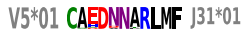

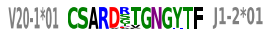

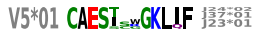

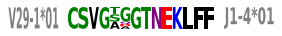

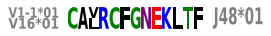

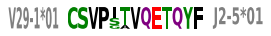

In [8]:
epitope='BMLF'
tcrs = d[d['epitope']==epitope]
cluster_number, count = np.unique(cluster, return_counts=True)
for cl in cluster_number[count>=4]:
    tcrs_cluster = tcrs[cluster==cl]
    print(tcrs_cluster[["v_a_gene", 'j_a_gene', 'v_b_gene', 'j_b_gene']].value_counts())
    print(cl, len(tcrs_cluster))
    for i, chain in enumerate(['alpha', 'beta']):
        axes = pp.seqlogos_vj(tcrs_cluster, cdr3_columns[chain],
                             'v_{c}_gene'.format(c=chain[0]),
                             'j_{c}_gene'.format(c=chain[0]))
        axes[0].get_figure().savefig(f'figures/raw/figure1_logo_{chain}_{cl}.svg')